In [2]:
import kagglehub

path = kagglehub.dataset_download("berkanoztas/synthetic-transaction-monitoring-dataset-aml")

print("Path to dataset files:", path)

100%|██████████| 193M/193M [00:03<00:00, 60.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/berkanoztas/synthetic-transaction-monitoring-dataset-aml/versions/2


In [3]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans

data = dd.read_csv('/root/.cache/kagglehub/datasets/berkanoztas/synthetic-transaction-monitoring-dataset-aml/versions/2/SAML-D.csv')
print(data.head())


       Time        Date  Sender_account  Receiver_account    Amount  \
0  10:35:19  2022-10-07      8724731955        2769355426   1459.15   
1  10:35:20  2022-10-07      1491989064        8401255335   6019.64   
2  10:35:20  2022-10-07       287305149        4404767002  14328.44   
3  10:35:21  2022-10-07      5376652437        9600420220  11895.00   
4  10:35:21  2022-10-07      9614186178        3803336972    115.25   

  Payment_currency Received_currency Sender_bank_location  \
0        UK pounds         UK pounds                   UK   
1        UK pounds            Dirham                   UK   
2        UK pounds         UK pounds                   UK   
3        UK pounds         UK pounds                   UK   
4        UK pounds         UK pounds                   UK   

  Receiver_bank_location  Payment_type  Is_laundering       Laundering_type  
0                     UK  Cash Deposit              0  Normal_Cash_Deposits  
1                    UAE  Cross-border            

In [4]:
# PART 1 - FEATURE ENGINEERING

# 1. Transaction Frequency by Account
# Converting 'Date' column to datetime to enable date-based operations

data['Date'] = dd.to_datetime(data['Date'])
data['Time'] = dd.to_datetime(data['Time']).dt.hour  # Extract the hour component

daily_counts = data.groupby(['Sender_account', 'Date']).size().reset_index()
daily_counts = daily_counts.rename(columns={0: 'Transaction_count_per_day'})

hourly_counts = data.groupby(['Sender_account', 'Date', 'Time']).size().reset_index()
hourly_counts = hourly_counts.rename(columns={0: 'Transaction_count_per_hour'})

data = data.merge(daily_counts, on=['Sender_account', 'Date'], how='left')
data = data.merge(hourly_counts, on=['Sender_account', 'Date', 'Time'], how='left')

data = data.compute()

# 2. Average Transaction Amount per Account
avg_amount = data.groupby('Sender_account')['Amount'].mean().rename('Avg_transaction_amount')
data = data.join(avg_amount, on='Sender_account')

# 3. Amount Relative to Average Transaction Amount
data['Amount_relative_to_avg'] = data['Amount'] / data['Avg_transaction_amount']

# 4. Transaction Amount in Suspicious Ranges
# example threshold just below regulatory limit
suspicious_threshold = 9999
data['Suspicious_amount_flag'] = (data['Amount'] >= suspicious_threshold).astype(int)

# 5. Flag Currency Mismatch
data['Currency_location_mismatch'] = (data['Payment_currency'] != data['Received_currency']).astype(int)

# 6. Sender and Receiver Account Overlap
data['Frequent_sender_receiver_pair'] = data.groupby(['Sender_account', 'Receiver_account'])['Date'].transform('count')

# 7. High-Risk Receiver Countries
high_risk_countries = ['Country1', 'Country2', 'Country3']  # Replace with actual high-risk country list
data['High_risk_country_flag'] = data['Receiver_bank_location'].isin(high_risk_countries).astype(int)

# 8. Repeated Small Amounts to Multiple Receivers (Fan-Out Transactions)
small_amount_threshold = 100  # example threshold for small transactions
data['Fan_out_transactions_count'] = data.groupby('Sender_account')['Amount'].transform(lambda x: (x < small_amount_threshold).sum())

# 9. Suspicious Time of Day (e.g., transactions outside business hours)
data['Transaction_time_flag'] = data['Time'].apply(lambda x: 1 if (x < 6) or (x > 22) else 0)

# Display the updated DataFrame with new flags and metrics
print(data.head())


/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:7164: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:7164: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:7164: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:7164: UserWarning: Could not infer format, so each element will be parsed individually, fal

   Time       Date  Sender_account  Receiver_account    Amount  \
0    10 2022-10-07      8724731955        2769355426   1459.15   
1    10 2022-10-07      1491989064        8401255335   6019.64   
2    10 2022-10-07       287305149        4404767002  14328.44   
3    10 2022-10-07      5376652437        9600420220  11895.00   
4    10 2022-10-07      9614186178        3803336972    115.25   

  Payment_currency Received_currency Sender_bank_location  \
0        UK pounds         UK pounds                   UK   
1        UK pounds            Dirham                   UK   
2        UK pounds         UK pounds                   UK   
3        UK pounds         UK pounds                   UK   
4        UK pounds         UK pounds                   UK   

  Receiver_bank_location  Payment_type  ...  Transaction_count_per_day  \
0                     UK  Cash Deposit  ...                          1   
1                    UAE  Cross-border  ...                        102   
2             

In [5]:
# PART 2 - Define Suspicion Rules and Create Suspicion Score

# 2.1 - Define Weights for Flags

weights = {
    'frequency': 1,
    'amount': 3,  # Higher weight for amount flags
    'currency_location': 3,  # Higher weight for currency/location flags
    'fan_out': 1,
    'time': 2,
    'high_risk_country': 3,
    'payment_type': 2,  # New weight for payment type flags
    'sender_receiver_pair': 2,  # New weight for sender-receiver pair flags
    'velocity': 2,  # New weight for velocity flags
}

# 2.2 - Define Transaction Limits and Thresholds

daily_transaction_limit = 50  # Maximum transactions per day
hourly_transaction_limit = 10  # Maximum transactions per hour
high_amount_threshold = 10000  # Threshold for high transactions
fan_out_threshold = 5  # Threshold for fan-out transactions
velocity_threshold = 20  # Threshold for transaction count velocity
suspicion_score_threshold = 10  # Threshold for suspicion score to flag as suspicious

# 2.3 - Flagging Logic

data['Suspicious_frequency'] = (
    (data['Transaction_count_per_day'] > daily_transaction_limit) |
    (data['Transaction_count_per_hour'] > hourly_transaction_limit)
).astype(int)

data['Suspicious_amount'] = (data['Amount_relative_to_avg'] > high_amount_threshold).astype(int)

data['Suspicious_currency_location'] = (
    (data['Currency_location_mismatch'] == 1) |
    (data['High_risk_country_flag'] == 1)
).astype(int)

data['Suspicious_fan_out'] = (data['Fan_out_transactions_count'] > fan_out_threshold).astype(int)

data['Suspicious_time'] = (data['Transaction_time_flag'] == 1).astype(int)

# 2.4 - Additional Flags for High-Risk Transactions

data['High_transaction_to_high_risk_country'] = (
    (data['Amount'] > high_amount_threshold) &
    (data['High_risk_country_flag'] == 1)
).astype(int)

# 2.5 - Flagging Logic for Payment Type

data['Suspicious_payment_type'] = data['Payment_type'].isin(['cash', 'international_transfer']).astype(int)

# Step 1: Calculate the count of transactions for each sender-receiver pair
# Create a DataFrame with the count of transactions per sender-receiver pair
frequent_pairs = (
    data.groupby(['Sender_account', 'Receiver_account'])
    .size()
    .reset_index(name='Frequent_sender_receiver_pair_count')  # Renamed for clarity
)

# Debugging Step: Print the frequent_pairs DataFrame to verify
print("frequent_pairs DataFrame:\n", frequent_pairs.head())

# Merge the frequent_pairs DataFrame with the original data
data = data.merge(
    frequent_pairs,
    on=['Sender_account', 'Receiver_account'],
    how='left'
)

# Verify the merge
print("Columns in data after merging:\n", data.columns)
print(data[['Sender_account', 'Receiver_account', 'Frequent_sender_receiver_pair_count']].head())

# 2.6 - Implement Velocity Checks

data['Transaction_velocity'] = (
    data['Transaction_count_per_hour'].rolling(window=24).mean().shift(1) > velocity_threshold
).astype(int)

# 2.7 - Create a Comprehensive Suspicion Score

data['Suspicion_score'] = (
    weights['frequency'] * data['Suspicious_frequency'] +
    weights['amount'] * data['Suspicious_amount'] +
    weights['currency_location'] * data['Suspicious_currency_location'] +
    weights['fan_out'] * data['Suspicious_fan_out'] +
    weights['time'] * data['Suspicious_time'] +
    weights['high_risk_country'] * data['High_transaction_to_high_risk_country'] +
    weights['payment_type'] * data['Suspicious_payment_type'] +
    weights['sender_receiver_pair'] * data['Frequent_sender_receiver_pair_count'] +
    weights['velocity'] * data['Transaction_velocity']
)

# 2.8 - Filter Suspicious Transactions

suspicious_transactions = data[data['Suspicion_score'] > suspicion_score_threshold]  # Adjust threshold as needed


frequent_pairs DataFrame:
    Sender_account  Receiver_account  Frequent_sender_receiver_pair_count
0            9018        2388293593                                    1
1           28511        3072405466                                    7
2           32095        6045686021                                   12
3           58673        6527756886                                    1
4           61549        3951053115                                   12
Columns in data after merging:
 Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Is_laundering',
       'Laundering_type', 'Transaction_count_per_day',
       'Transaction_count_per_hour', 'Avg_transaction_amount',
       'Amount_relative_to_avg', 'Suspicious_amount_flag',
       'Currency_location_mismatch', 'Frequent_sender_receiver_pair',
       'High_risk_country_flag', 'Fan_out_trans

In [6]:
# 3. Generate a Comprehensive Summary Report

summary_report = suspicious_transactions.groupby(['Sender_account', 'Date']).agg(
    Total_Transactions=('Amount', 'count'),  # Use 'Amount' as it matches your column
    Total_Suspicious_Amount=('Amount', 'sum'),
    Max_Suspicion_Score=('Suspicion_score', 'max'),
    Average_Transaction_Amount=('Amount', 'mean'),
    Total_Suspicious_Flags=('Suspicion_score', 'count'),
    Unique_Receivers=('Receiver_account', 'nunique')
).reset_index()

# Adding a new column for Percentage of Total Suspicious Amount
summary_report['Percentage_of_Total_Suspicious_Amount'] = (
    summary_report['Total_Suspicious_Amount'] / summary_report['Total_Suspicious_Amount'].sum() * 100
).round(2)

# Display report
print(summary_report)


         Sender_account       Date  Total_Transactions  \
0                 28511 2023-01-24                   1   
1                 28511 2023-02-24                   1   
2                 28511 2023-03-24                   1   
3                 28511 2023-04-24                   1   
4                 28511 2023-05-24                   1   
...                 ...        ...                 ...   
3445498      9999819588 2023-07-11                   1   
3445499      9999819588 2023-08-11                   1   
3445500      9999862026 2023-01-20                  12   
3445501      9999913136 2022-11-01                  12   
3445502      9999986843 2023-06-15                  12   

         Total_Suspicious_Amount  Max_Suspicion_Score  \
0                        6371.25                   16   
1                        3878.00                   16   
2                        4109.92                   14   
3                        7147.58                   14   
4                 

High-Risk Accounts Summary:
         Sender_account       Date  Total_Transactions  \
0                 28511 2023-01-24                   1   
1                 28511 2023-02-24                   1   
2                 28511 2023-03-24                   1   
3                 28511 2023-04-24                   1   
4                 28511 2023-05-24                   1   
...                 ...        ...                 ...   
3445498      9999819588 2023-07-11                   1   
3445499      9999819588 2023-08-11                   1   
3445500      9999862026 2023-01-20                  12   
3445501      9999913136 2022-11-01                  12   
3445502      9999986843 2023-06-15                  12   

         Total_Suspicious_Amount  Max_Suspicion_Score  \
0                        6371.25                   16   
1                        3878.00                   16   
2                        4109.92                   14   
3                        7147.58               

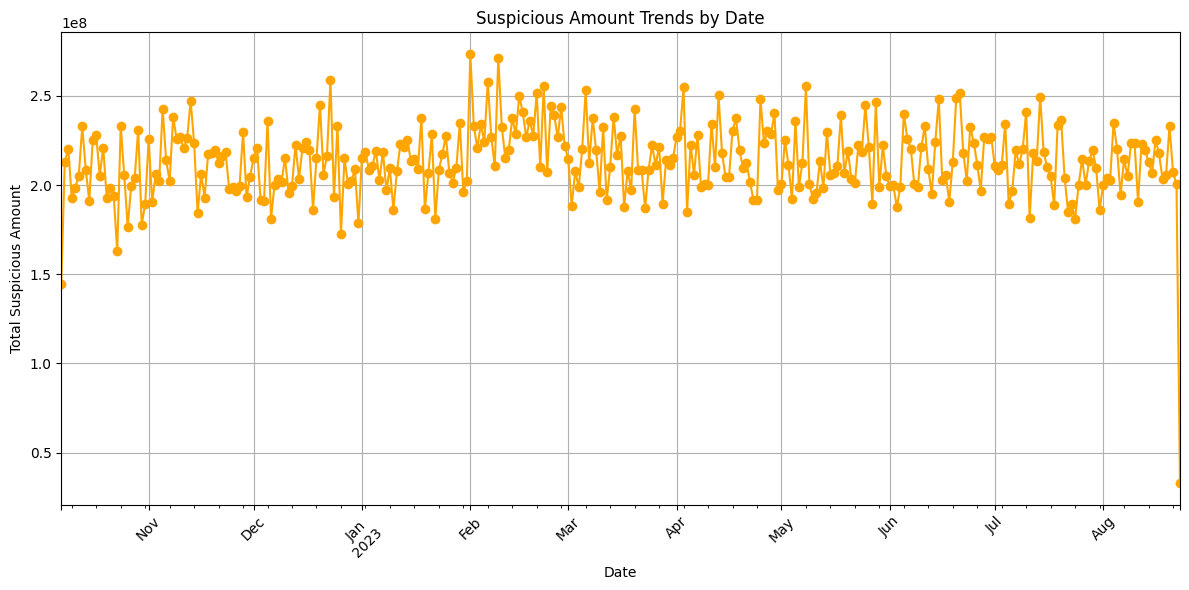

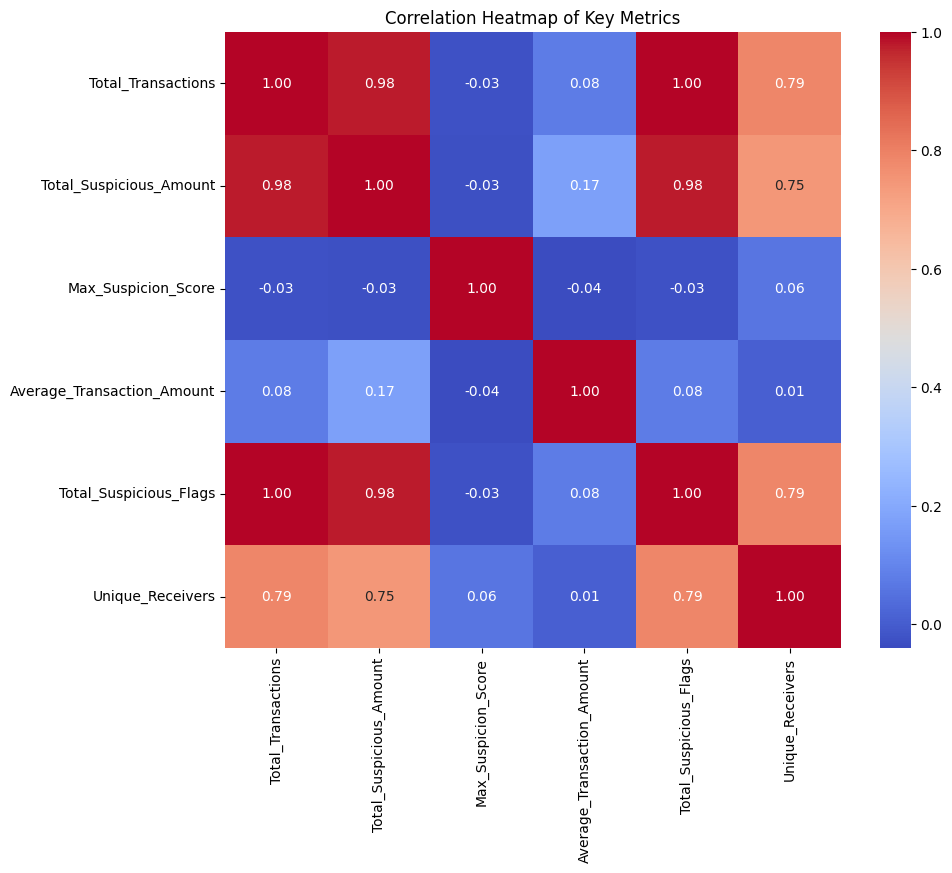

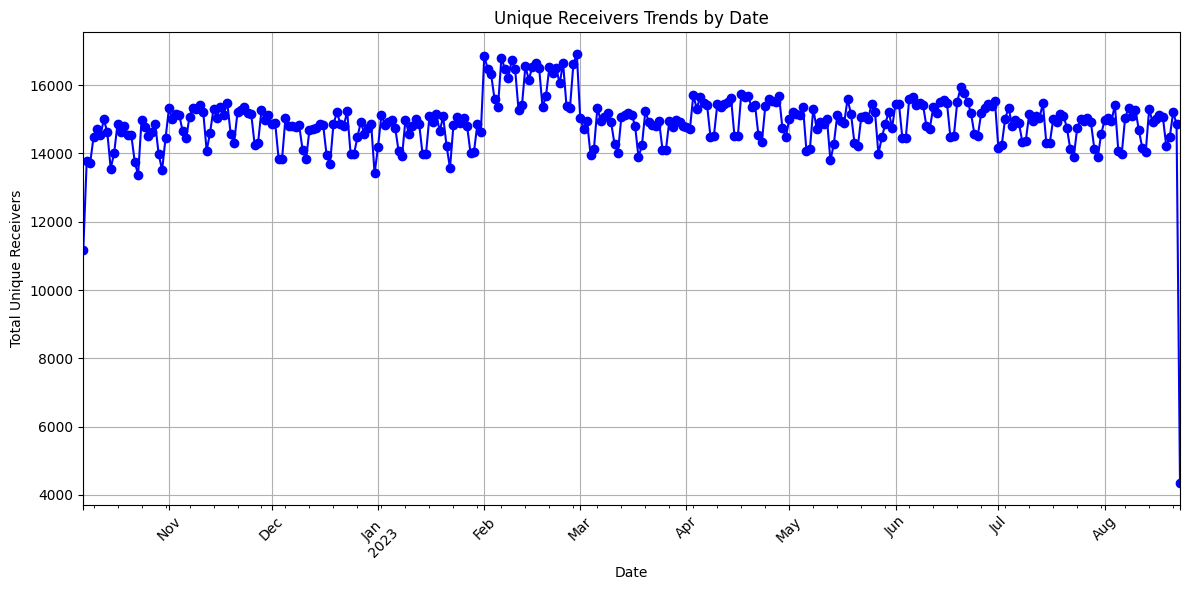

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# 4. Exploratory Analysis

# 4.1 - High-risk accounts summary
high_risk_accounts = summary_report[summary_report['Max_Suspicion_Score'] > 2]
print("High-Risk Accounts Summary:")
print(high_risk_accounts)

# 4.2 - Frequency of high-risk accounts
frequent_high_risk_accounts = summary_report[summary_report['Total_Suspicious_Flags'] > 1] \
    .groupby('Sender_account').size().sort_values(ascending=False)
print("\nFrequency of High-Risk Accounts:")
print(frequent_high_risk_accounts)

# 4.3 - Top suspicious amounts
top_suspicious_amounts = summary_report.sort_values(by='Total_Suspicious_Amount', ascending=False).head(10)
print("\nTop Suspicious Amounts:")
print(top_suspicious_amounts)

# 4.4 - Suspicious transaction trends over time
date_trends = summary_report.groupby('Date')['Total_Suspicious_Amount'].sum()

plt.figure(figsize=(12, 6))
date_trends.plot(kind='line', title='Suspicious Amount Trends by Date', marker='o', color='orange')
plt.xlabel('Date')
plt.ylabel('Total Suspicious Amount')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# 4.5 - Additional Analysis: Correlation Heatmap
correlation_matrix = summary_report[['Total_Transactions', 'Total_Suspicious_Amount',
                                     'Max_Suspicion_Score', 'Average_Transaction_Amount',
                                     'Total_Suspicious_Flags', 'Unique_Receivers']].corr()

plt.figure(figsize=(10, 8))
plt.title('Correlation Heatmap of Key Metrics')
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.show()

# 4.6 - Trend of Unique Receivers Over Time
unique_receivers_trends = summary_report.groupby('Date')['Unique_Receivers'].sum()

plt.figure(figsize=(12, 6))
unique_receivers_trends.plot(kind='line', title='Unique Receivers Trends by Date', marker='o', color='blue')
plt.xlabel('Date')
plt.ylabel('Total Unique Receivers')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [8]:
# 5. Advanced Anomaly Detection

# 5.1 - Calculate Z-scores for suspicious amounts
summary_report['Amount_Z_Score'] = (summary_report['Total_Suspicious_Amount'] -
                                      summary_report['Total_Suspicious_Amount'].mean()) / summary_report['Total_Suspicious_Amount'].std()

# 5.2 - Calculate Z-scores for total transactions
summary_report['Transaction_Z_Score'] = (summary_report['Total_Transactions'] -
                                           summary_report['Total_Transactions'].mean()) / summary_report['Total_Transactions'].std()

# 5.3 Calculate IQR for suspicious amounts
Q1 = summary_report['Total_Suspicious_Amount'].quantile(0.25)
Q3 = summary_report['Total_Suspicious_Amount'].quantile(0.75)
IQR = Q3 - Q1

# 5.4 - Define lower and upper bounds for IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 5.5 - Filter anomalous transactions based on Z-scores
anomalous_transactions_z = summary_report[(summary_report['Amount_Z_Score'] > 3) |
                                          (summary_report['Transaction_Z_Score'] > 3)]

# 5.6 - Filter anomalous transactions based on IQR
anomalous_transactions_iqr = summary_report[(summary_report['Total_Suspicious_Amount'] < lower_bound) |
                                             (summary_report['Total_Suspicious_Amount'] > upper_bound)]

# 5.7 - Combine anomalous transactions from both methods
combined_anomalous_transactions = pd.concat([anomalous_transactions_z, anomalous_transactions_iqr]).drop_duplicates()

# Display the results
print("Anomalous Transactions based on Z-Scores and IQR:")
print(combined_anomalous_transactions)

Anomalous Transactions based on Z-Scores and IQR:
         Sender_account       Date  Total_Transactions  \
415              716444 2023-07-04                 247   
821             2207173 2023-03-01                 238   
1019            2462474 2023-02-17                 130   
1251            3454889 2023-06-06                 104   
1539            5038103 2023-04-27                 119   
...                 ...        ...                 ...   
3445498      9999819588 2023-07-11                   1   
3445499      9999819588 2023-08-11                   1   
3445500      9999862026 2023-01-20                  12   
3445501      9999913136 2022-11-01                  12   
3445502      9999986843 2023-06-15                  12   

         Total_Suspicious_Amount  Max_Suspicion_Score  \
415                   2250487.08                   33   
821                   2693614.44                   44   
1019                  1354983.06                   33   
1251                  106

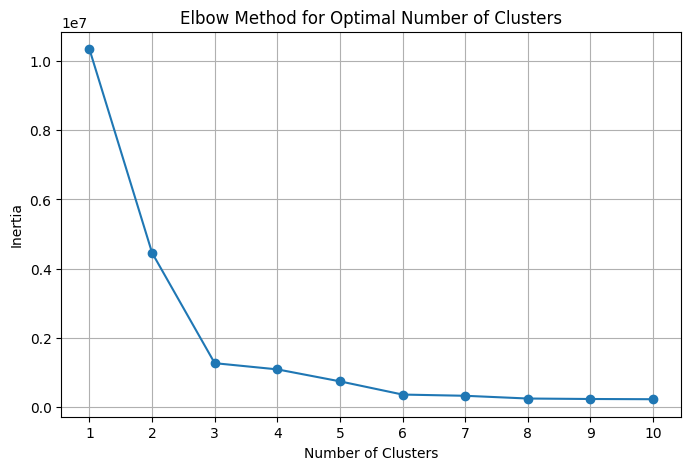

Cluster Analysis:
         Sender_account                          Date  Total_Transactions  \
Cluster                                                                     
0          5.012874e+09 2023-03-16 18:14:54.938129920            2.056395   
1          5.008918e+09 2023-03-14 14:11:04.668922368          181.610843   
2          5.046569e+09 2023-03-15 13:00:23.029711104            1.519473   

         Total_Suspicious_Amount  Max_Suspicion_Score  \
Cluster                                                 
0                   1.383677e+04            30.952982   
1                   1.835833e+06            33.973337   
2                   7.645811e+03           148.519381   

         Average_Transaction_Amount  Total_Suspicious_Flags  Unique_Receivers  \
Cluster                                                                         
0                       5141.893898                2.056395          1.336216   
1                      10136.654453              181.610843        

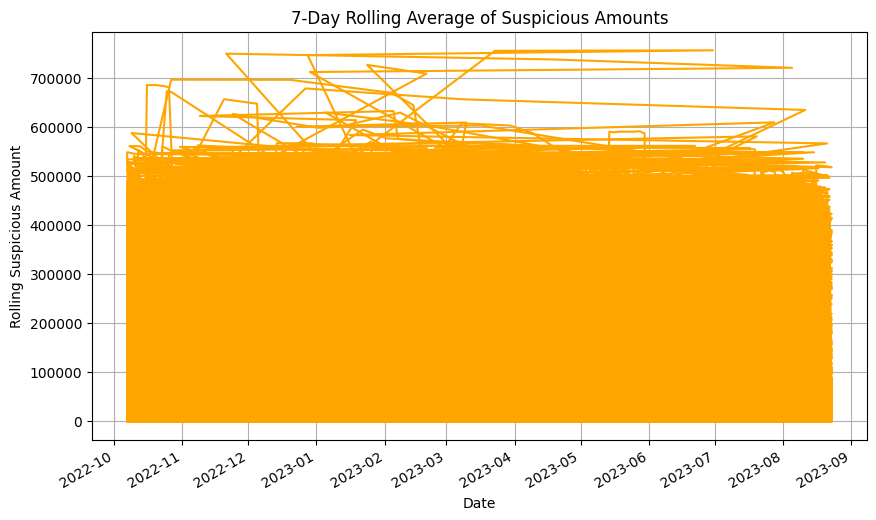

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# 6. K-Means Clustering on Transaction Features

# 6.1 - Select columns for clustering
clustering_features = summary_report[['Total_Transactions', 'Total_Suspicious_Amount', 'Max_Suspicion_Score']]

# 6.2 - Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# 6.3 - Determine the optimal number of clusters using the Elbow method
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# 6.4 - Plot Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

# 6.5 - Applying K-Means clustering with the optimal number of clusters (chosen based on the elbow method)
optimal_clusters = 3  # Adjust this based on the Elbow method results
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
summary_report['Cluster'] = kmeans.fit_predict(scaled_features)

# 6.6 - Cluster analysis
cluster_analysis = summary_report.groupby('Cluster').mean()
print("Cluster Analysis:")
print(cluster_analysis)

# 6.7 - Rolling average of suspicious transactions over time
summary_report['Date'] = pd.to_datetime(summary_report['Date'])
summary_report.set_index('Date', inplace=True)

# 6.6 - Calculate rolling average for a specified window
summary_report['Rolling_Suspicious_Amount'] = summary_report['Total_Suspicious_Amount'].rolling(window=7).mean()

# 6.7 - Plotting the rolling average
plt.figure(figsize=(10, 6))
# Set the chunksize for this plot as well
plt.rcParams['agg.path.chunksize'] = 10000
summary_report['Rolling_Suspicious_Amount'].plot(title="7-Day Rolling Average of Suspicious Amounts", color='orange')
plt.xlabel('Date')
plt.ylabel('Rolling Suspicious Amount')
plt.grid()
plt.show()


In [ ]:
# PART 7 - Transaction Network Visualization
# ---------------------------------------------------------

# Create a directed graph from the DataFrame
G = nx.from_pandas_edgelist(data, source='Sender_account', target='Receiver_account',
                             edge_attr='Amount', create_using=nx.DiGraph())

# Filter edges based on a threshold to highlight high-value transactions
amount_threshold = 10000  # Define your threshold for high-value transactions
high_value_edges = [(u, v) for u, v, d in G.edges(data=True) if d['Amount'] > amount_threshold]

# Create a subgraph with high-value edges
H = G.edge_subgraph(high_value_edges)

# Set node sizes based on the degree (number of transactions)
node_sizes = [G.out_degree(node) * 20 for node in G.nodes()]  # Scale node size for better visibility

# Get edge colors based on amounts
edge_colors = ['red' if G[u][v]['Amount'] > amount_threshold else 'gray' for u, v in G.edges()]

# Plot network
plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G, k=0.5)  # Positions for all nodes using Fruchterman-Reingold layout
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=0.5, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

# Highlight high-value transactions
if len(H.edges()) > 0:
    nx.draw_networkx_edges(H, pos, edge_color='red', width=2.5, arrows=True)

plt.title("Transaction Network Visualization with High-Value Transactions Highlighted")
plt.axis('off')  # Hide the axis
plt.show()

KeyboardInterrupt: 

<Figure size 1400x1400 with 0 Axes>

In [12]:
# PART 7 - Preparing Data for Machine Learning- Ensure derived features in suspicious_transactions before aggregation if not already calculated

# Assuming Amount_Z_Score is a z-score of the 'Amount' column, calculate it
suspicious_transactions['Amount_Z_Score'] = (suspicious_transactions['Amount'] - suspicious_transactions['Amount'].mean()) / suspicious_transactions['Amount'].std()

# Ensure other flags are created or directly add them to summary_report
# Example: Convert High_transaction_to_high_risk_country, Suspicious_payment_type, etc., to binary if needed
suspicious_transactions['High_transaction_to_high_risk_country'] = suspicious_transactions['High_transaction_to_high_risk_country'].astype(int)
suspicious_transactions['Suspicious_payment_type'] = suspicious_transactions['Suspicious_payment_type'].astype(int)
suspicious_transactions['Frequent_sender_receiver_pair'] = suspicious_transactions['Frequent_sender_receiver_pair'].astype(int)
suspicious_transactions['Transaction_velocity'] = suspicious_transactions['Transaction_velocity']

# Re-create summary_report with these new columns included in the aggregation
summary_report = suspicious_transactions.groupby(['Sender_account', 'Date']).agg(
    Total_Transactions=('Amount', 'count'),
    Total_Suspicious_Amount=('Amount', 'sum'),
    Max_Suspicion_Score=('Suspicion_score', 'max'),
    Amount_Z_Score=('Amount_Z_Score', 'mean'),              # Aggregated mean z-score
    High_transaction_to_high_risk_country=('High_transaction_to_high_risk_country', 'max'),
    Suspicious_payment_type=('Suspicious_payment_type', 'max'),
    Frequent_sender_receiver_pair=('Frequent_sender_receiver_pair', 'max'),
    Transaction_velocity=('Transaction_velocity', 'mean'),
    Is_laundering=('Is_laundering', 'max')
).reset_index()

# Convert 'Date' to datetime and set as index
summary_report['Date'] = pd.to_datetime(summary_report['Date'])
summary_report.set_index('Date', inplace=True)

# Redefine target and features
y = summary_report['Is_laundering']
X = summary_report[['Total_Transactions',
                    'Total_Suspicious_Amount',
                    'Max_Suspicion_Score',
                    'Amount_Z_Score',
                    'High_transaction_to_high_risk_country',
                    'Suspicious_payment_type',
                    'Frequent_sender_receiver_pair',
                    'Transaction_velocity']]




<ipython-input-12-8a40f03606bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suspicious_transactions['Amount_Z_Score'] = (suspicious_transactions['Amount'] - suspicious_transactions['Amount'].mean()) / suspicious_transactions['Amount'].std()
<ipython-input-12-8a40f03606bf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suspicious_transactions['High_transaction_to_high_risk_country'] = suspicious_transactions['High_transaction_to_high_risk_country'].astype(int)
<ipython-input-12-8a40f03606bf>:9: Settin

In [13]:
# PART 8 -
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Summary of the data preparation
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 2411852 samples
Testing set size: 1033651 samples


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1033073
           1       0.04      0.02      0.02       578

    accuracy                           1.00   1033651
   macro avg       0.52      0.51      0.51   1033651
weighted avg       1.00      1.00      1.00   1033651

Confusion Matrix:
 [[1032834     239]
 [    569       9]]
Accuracy Score: 0.9992183048243556


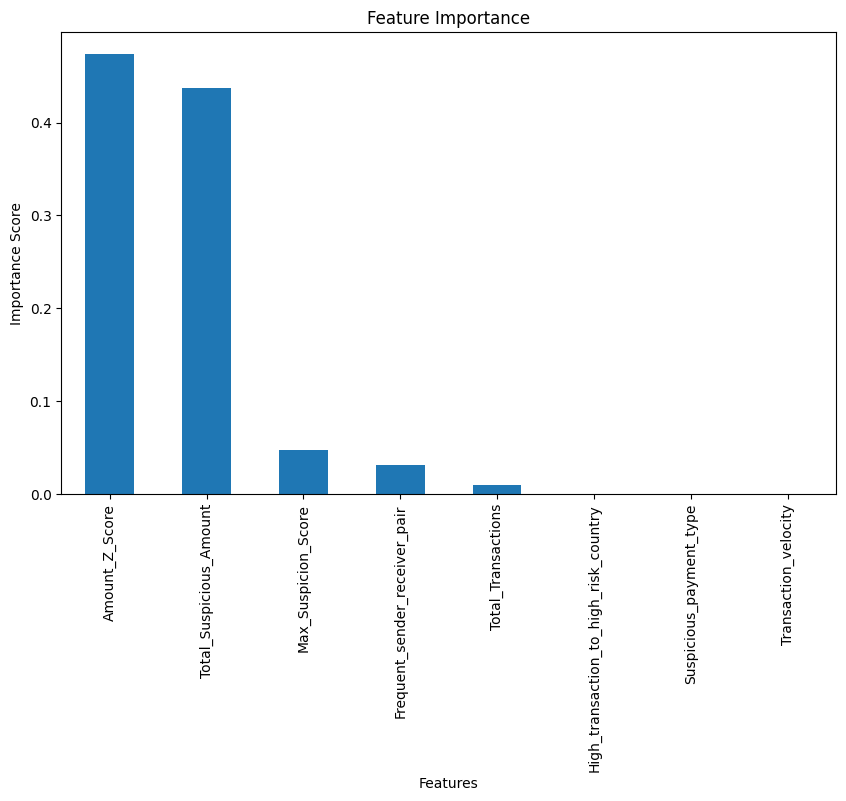

Cross-validated accuracy: 1.00 ± 0.00


In [14]:
# PART 9 - Train and Evaluate RandomForest Model


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train RandomForest model with hyperparameters
model = RandomForestClassifier(n_estimators=100,  # Number of trees in the forest
                               max_depth=None,    # Maximum depth of the tree
                               min_samples_split=2,  # Minimum samples required to split an internal node
                               min_samples_leaf=1,    # Minimum samples required to be at a leaf node
                               random_state=42)      # For reproducibility

model.fit(X_train_scaled, y_train)  # Fit the model with scaled data

# Predict and evaluate
y_pred = model.predict(X_test_scaled)  # Predict using scaled test data

# Evaluation Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Feature Importance Analysis
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Display Feature Importances
plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

# Optional: Save the model for future use
import joblib
joblib.dump(model, 'random_forest_model.pkl')

# Optional: Cross-validation for better evaluation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f"Cross-validated accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
